In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf
from pymer4.models import Lmer
from pymer4.simulate import easy_multivariate_normal
rng = np.random.default_rng()
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression
import itertools

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

import seaborn as sns
%matplotlib inline
pd.set_option("display.max_rows", 100)

# look at the distribution of residuals

In [2]:
def kfold_linear(data, model):
    kf = KFold(n_splits=8)
    fits = []
    reses = []
    for fix, (train_ind, test_ind) in enumerate(kf.split(data)):
        mdl = smf.ols(model, data.loc[train_ind])
        fitted = mdl.fit()
        res = data.loc[test_ind, ['SDAN'] + [mdl.endog_names]].copy()
        res[f'{mdl.endog_names}_predicted'] = fitted.predict(data.loc[test_ind])
        res['fold'] = fix
        reses.append(res)
        fits.append(fitted)
    reses = pd.concat(reses)
    return fits, reses

def kfold_lme(data, model, other_vars = None):
    gkf = GroupKFold(n_splits=8)
    fit_mdls = []
    reses = []
    for tix,(train_ind, test_ind) in enumerate(gkf.split(data, groups=data.SDAN)):
        mdl = Lmer(model, data.loc[train_ind])
        _ = mdl.fit()
        y_name = model.split("~")[0].strip()
        vars_to_copy = ['SDAN'] + [y_name]
        if other_vars is not None:
            vars_to_copy.extend(other_vars)
        res = data.loc[test_ind, vars_to_copy].copy()
        res[f'{y_name}_predicted'] = mdl.predict(data.loc[test_ind])
        res['fold'] = tix
        reses.append(res)
        fit_mdls.append(mdl)
    reses = pd.concat(reses)
    return fit_mdls, reses

def get_rsquared(var, df):
    var_pred = var + '_predicted'
    num = ((df[var] - df[var_pred])**2).sum()
    den = ((df[var] - df[var].mean())**2).sum()
    r_squared = 1 - (num / den)
    return r_squared

def get_95ci(var, df):
    means = []
    for inds in itertools.product(df.index, repeat=len(df.index)):
        vals = []
        for ix in inds:
            vals.append(df.loc[ix, var])
        means.append(np.mean(vals))
    lci, uci = np.percentile(means, [2.5, 97.5])
    return pd.Series({f'{var}_lci': lci, f'{var}_uci':uci})

def get_99ci(var, df):
    means = []
    for inds in itertools.product(df.index, repeat=len(df.index)):
        vals = []
        for ix in inds:
            vals.append(df.loc[ix, var])
        means.append(np.mean(vals))
    lci, uci = np.percentile(means, [0.5, 99.5])
    return pd.Series({f'{var}_lci': lci, f'{var}_uci':uci})

def get_999ci(var, df):
    means = []
    bootstrap_folds = list(itertools.product(df.index, repeat=len(df.index)))
    bootstrap_folds = set([tuple(sorted(x)) for x in bootstrap_folds])
    for inds in bootstrap_folds:
        vals = []
        for ix in inds:
            vals.append(df.loc[ix, var])
        means.append(np.mean(vals))
    lci, uci = np.percentile(means, [0.05, 99.95])
    return pd.Series({f'{var}_lci': lci, f'{var}_uci':uci})

def corr_plot(corr, for_cors, alpha=0.05, bonferoni_denomenator=None, cluster_var=None):
    mask = np.tril(np.ones_like(corr, dtype=bool))
    annots = corr.copy()
    ps = corr.copy()
    if bonferoni_denomenator is None:
        bonferoni_alpha = alpha/mask.sum()
    else:
        bonferoni_alpha = alpha/bonferoni_denomenator
    for ix,row in corr.iterrows():
        for name in row.index:
            if cluster_var is None:
                r, p = stats.pearsonr(for_cors[ix], for_cors[name])
            elif ix == name:
                p = np.nan
            else:
                zs = for_cors.loc[for_cors['level_1'] == ix, name]
                zs = zs[pd.notnull(zs)]
                t, p = stats.ttest_1samp(zs, 0)
                mean = np.tanh(for_cors.loc[for_cors['level_1'] == ix, name].mean())
                se = np.tanh(for_cors.loc[for_cors['level_1'] == ix, name].std() / np.sqrt(for_cors[cluster_var].nunique()))
                dof = for_cors[cluster_var].nunique() - 1
            ps.loc[ix, name] = p
            annot = f"${corr.loc[ix, name]:0.2g}"
    #         if cluster_var is not None:
    #             se = np.tanh(for_cors.loc[for_cors['level_1'] == ix, name].std() / np.sqrt(for_cors[cluster_var].nunique()))
    #             annot += f"\pm{se:0.2g}"
            if p < bonferoni_alpha:
                if cluster_var is None:
                    if ix != name:
                        print(ix, name, r, len(for_cors[ix]), p )
                else:
                    print(ix, name, mean, se, t, dof, p)
                annot += "^*$"
            else:
                annot += "$"
            annots.loc[ix, name] = annot
    corr.index.name = None
    fig, ax = plt.subplots(figsize=(11, 9), dpi=250)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr.iloc[:-1, 1:], mask=mask[:-1, 1:], cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                annot=annots.iloc[:-1, 1:], fmt="")
    return fig,ax

def foldwise_bootstrap(df):
    bsdf = df.merge(boot_skeleton, how='left')
    bsdf['dif'] = bsdf.sim - bsdf.null
    bsdf = bsdf.drop(['null', 'sim'], axis=1)
    bs_res = bsdf.groupby(['metric', 'bsi', 'sim_number']).mean().reset_index()
    bs_res = bs_res.drop(['bsfold', 'fold'], axis=1)
    return bs_res.dif.describe(percentiles=[0.0005, 0.025, 0.975, 0.9995])

def gskde(x, **kwargs):
    grid = GridSearchCV(KernelDensity(**kwargs),
                    {'bandwidth': np.linspace(0.1, 10, 1000)},
                    cv=5)
    grid.fit(x)
    print(grid.best_params_)
    kde = KernelDensity(bandwidth=grid.best_params_['bandwidth'])
    kde.fit(x)
    xgrid = np.linspace(x.min(), x.max(), 5000)
    pdf = np.exp(kde.score_samples(xgrid[:, None]))
    fig, ax = plt.subplots()
    ax.plot(xgrid, pdf, linewidth=3, alpha=0.5, label='bw=%.2f' % kde.bandwidth)
    ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)

    ax.legend(loc='upper left')
    return kde

In [3]:
wdat = pd.read_csv('../data/WeeksofDepression5.24.2021reduced.csv', index_col=0).reset_index(drop=True)
wdat = wdat.rename(columns={'AgeatV1': 'Age_at_visit',
                            'v1MFQScore': 'BaselineMFQScore'})
pure_dat = wdat.copy()
wdat = wdat.loc[(wdat.drop(['v4MFQDate', 'v4MFQScore'], axis=1).isnull().sum(1)==0)].copy()
# make sure each subject is only in there once
assert len(wdat.groupby('SDAN')[['Participant_Type2']].count().query('Participant_Type2 > 1')) == 0
# make sure there are 72 people with no nulls
assert (wdat.drop(['v4MFQDate', 'v4MFQScore'], axis=1).isnull().sum(1)==0).sum() == 72
# make sure there are only MDDs in this group
assert wdat.Participant_Type2.unique()[0] == 'MDD'
# make sure there are only male and femal in the sex column
assert set(wdat.SEX.unique()) == {'FEMALE', 'MALE'}

In [4]:
models = {'Null':'c_ksadsdx_epset_annual_weeks_mdd ~ BaselineAntiDep + BaselineOtherMeds + FUAntiDep + FUOtherMeds + Inpatient + SEX + Age_at_visit + postpandemic',
          'FH':'c_ksadsdx_epset_annual_weeks_mdd ~ dep_immed + BaselineAntiDep + BaselineOtherMeds + FUAntiDep + FUOtherMeds + Inpatient + SEX + Age_at_visit + postpandemic',
          'MFQ':'c_ksadsdx_epset_annual_weeks_mdd ~ BaselineMFQScore + BaselineAntiDep + BaselineOtherMeds + FUAntiDep + FUOtherMeds + Inpatient + SEX + Age_at_visit + postpandemic',
          'MFQ+FH':'c_ksadsdx_epset_annual_weeks_mdd ~ BaselineMFQScore + dep_immed + BaselineAntiDep + BaselineOtherMeds + FUAntiDep + FUOtherMeds + Inpatient + SEX + Age_at_visit + postpandemic',
          'MFQ+FH+CASE':'c_ksadsdx_epset_annual_weeks_mdd ~ BaselineMFQScore + (dep_immed*s_case__neg_tot) + BaselineAntiDep + BaselineOtherMeds + FUAntiDep + FUOtherMeds + Inpatient + SEX + Age_at_visit + postpandemic',
          'BSL_Null': 'c_ksadsdx_epset_annual_weeks_mdd ~ BaselineAntiDep + BaselineOtherMeds + SEX + Age_at_visit + postpandemic',
          'BSL_FH': 'c_ksadsdx_epset_annual_weeks_mdd ~ dep_immed + BaselineAntiDep + BaselineOtherMeds + SEX + Age_at_visit + postpandemic',
          'BSL_MFQ': 'c_ksadsdx_epset_annual_weeks_mdd ~ BaselineMFQScore + BaselineAntiDep + BaselineOtherMeds + SEX + Age_at_visit + postpandemic',
          'BSL_MFQ+FH': 'c_ksadsdx_epset_annual_weeks_mdd ~ dep_immed + BaselineMFQScore + BaselineAntiDep + BaselineOtherMeds + SEX + Age_at_visit + postpandemic',
          }
model_names = list(models.keys())

In [5]:
var = 'c_ksadsdx_epset_annual_weeks_mdd'
var_pred = var + '_predicted'

In [6]:
reses = []
for mix, model in models.items():
    if "BSL" in mix:
        data = pure_dat.copy().reset_index(drop=True)
    else:
        data = wdat.copy().reset_index(drop=True)
    ffs, rrs = kfold_linear(data, model)
    rrs['model'] = mix
    reses.append(rrs)
reses = pd.concat(reses)
reses['squared_error'] = (reses[var] - reses[var_pred]) ** 2
reses['abs_error'] = np.abs((reses[var] - reses[var_pred]))
reses['error'] = (reses[var_pred] - reses[var])
mf_agg = reses.groupby(['model', 'fold']).apply(lambda x: get_rsquared(var, x)).reset_index(name='r-squared')
mf_agg['rmse'] = np.sqrt(reses.groupby(['model', 'fold']).squared_error.mean()).reset_index(name='rmse').loc[:, ['rmse']]
mf_agg['mae'] = reses.groupby(['model', 'fold']).abs_error.mean().reset_index(name='mae').loc[:, ['mae']]
to_plot = reses.copy()
to_plot = to_plot.rename(
    columns={
        'c_ksadsdx_epset_annual_weeks_mdd':'Actual Weeks of Depression',
        'c_ksadsdx_epset_annual_weeks_mdd_predicted':'Predicted Weeks of Depression',
        'model': 'Model',
        'fold': 'Fold'
    })


{'bandwidth': 7.324324324324325}


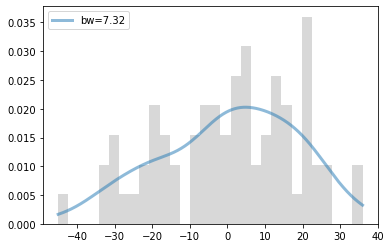

In [7]:
x = reses.loc[reses.model == 'MFQ+FH', 'error'].values.reshape(-1,1)

kde = gskde(x)

- Make a population of 10k
  - with a random effect and random subj_std each on the interval [0.5,2]
  - calculate effect sizes for MAE and RMSE in the population
- Draw 4 samples from it (n = 36, n = 72, n = 200, n = 1000)
- Run foldwise bootstrap for each sample

In [8]:
pop_n = 10000
npops = 2000
samp_ns = [36, 72, 200, 1000]

In [9]:
def pool_sim_sd(x0, x1):
    assert x0.shape == x1.shape
    n = x0.shape[0]
    v0 = x0.var(0)
    v1 = x1.var(0)
    return np.sqrt((v0 + v1)/2)

In [10]:
pop_nulls = kde.sample((pop_n, npops)).squeeze()
residual_changes = rng.uniform(0.25, 3, npops)
subj_stds = rng.uniform(0.5, 1, npops)
pop_effects = np.array([rng.normal(rc, ss, size=pop_n) for rc, ss in zip(residual_changes, subj_stds)]).T
pop_sims = pop_nulls * pop_effects

In [11]:
pop_nulls_sq = pop_nulls ** 2
pop_nulls_ae = np.abs(pop_nulls)

pop_sims_sq = pop_sims ** 2
pop_sims_ae = np.abs(pop_sims)

pop_ae_mds = pop_sims_ae.mean(0) - pop_nulls_ae.mean(0)
pop_ae_pds = pool_sim_sd(pop_nulls_ae, pop_sims_ae)
pop_ae_ds = pop_ae_mds / pop_ae_pds

pop_sq_mds = pop_sims_sq.mean(0) - pop_nulls_sq.mean(0)
pop_sq_pds = pool_sim_sd(pop_nulls_sq, pop_sims_sq)
pop_sq_ds = pop_sq_mds / pop_sq_pds

In [12]:
kfold = KFold(n_splits=8)

In [13]:
bootstrap_folds = list(itertools.product(range(8), repeat=8))
bootstrap_folds = set([tuple(sorted(x)) for x in bootstrap_folds])
boot_skeleton = []
for iix, inds in enumerate(bootstrap_folds):
    for bsfi, ix in enumerate(inds):
        row = {}
        row['bsi'] = iix
        row['bsfold'] = bsfi
        row['fold'] = ix
        boot_skeleton.append(row)
boot_skeleton = pd.DataFrame(boot_skeleton)

In [14]:
metrics = {'rmse':lambda x: x**2, 'mae': np.abs}

In [15]:
sim_dat = []
sim_number = -1
sim_info = []
for pi in range(npops):
    pop_null = pop_nulls[:, pi]
    pop_sim = pop_sims[:, pi]
    for n in samp_ns:
        sim_number += 1
        
        for metric in metrics.keys():
            si_row = {}
            si_row['sim_number'] = sim_number
            si_row['metric'] = metric
            si_row['n'] = n
            if metric == 'mae':
                si_row['pop_md'] = pop_ae_mds[pi]
                si_row['pop_pd'] = pop_ae_pds[pi]
                si_row['pop_d'] = pop_ae_ds[pi]
            elif metric == 'rmse':
                si_row['pop_md'] = pop_sq_mds[pi]
                si_row['pop_pd'] = pop_sq_pds[pi]
                si_row['pop_d'] = pop_sq_ds[pi]
            sim_info.append(si_row)
        sids = rng.choice(range(len(pop_null)), size=n, replace=False)
        samp_null = pop_null[sids]
        samp_sim = pop_sim[sids]
        folds = np.zeros(sids.shape)
        for kfi, (train_inds, test_inds) in enumerate(kfold.split(sids)):
            folds[test_inds] = kfi
        for metric, func in metrics.items():
            tmp_null = func(samp_null)
            tmp_sim = func(samp_sim)
            chunk = {}
            chunk['sim_number'] = [sim_number] * n
            #chunk['n'] = [n] * n
            chunk['metric'] = [metric] * n
            chunk['sid'] = sids
            chunk['fold'] = folds
            chunk['null'] = tmp_null
            chunk['sim'] = tmp_sim
            sim_dat.append(pd.DataFrame(chunk).copy())
sim_dat = pd.concat(sim_dat)
sim_info = pd.DataFrame(sim_info)

In [16]:
sim_agg = sim_dat.groupby([ 'sim_number','fold', 'metric']).mean().drop('sid', axis=1)
sim_agg.loc[(slice(None), slice(None), 'rmse'), :] = np.sqrt(sim_agg.xs('rmse', level="metric"))
sim_agg = sim_agg.reset_index()

In [17]:
sim_res = sim_agg.groupby(['sim_number', 'metric']).apply(foldwise_bootstrap)

In [18]:
sim_res = sim_res.reset_index()

In [19]:
sim_res['sig_pos'] = (np.sign(sim_res['0.05%']) == np.sign(sim_res['99.95%'])) & (sim_res['0.05%'] > 0)
sim_res['sig_neg'] = (np.sign(sim_res['0.05%']) == np.sign(sim_res['99.95%'])) & (sim_res['0.05%'] < 0)

In [20]:
sim_ri = sim_res.merge(sim_info, how='left', on=['sim_number', 'metric'])

In [21]:
sim_ri['type_s'] = (np.sign(sim_ri['0.05%']) == np.sign(sim_ri['99.95%'])) & (np.sign(sim_ri['0.05%']) != np.sign(sim_ri['pop_d']))
sim_ri['sig'] = sim_ri['sig_pos'] | sim_ri['sig_neg']
sim_ri['abs_d'] = np.abs(sim_ri.pop_d)

In [22]:
sim_ri.groupby('n').type_s.mean()

n
36      0.00025
72      0.00050
200     0.00000
1000    0.00000
Name: type_s, dtype: float64

In [34]:
# get number of bins
nbins = min(len(np.histogram_bin_edges(sim_ri.abs_d, bins="fd")), 50)
nbins = 24
_, bins = pd.cut(sim_ri.abs_d, nbins, retbins=True)
bin_labels = np.vstack((bins[:-1], bins[1:])).mean(0)
sim_ri['d_bin'] = pd.cut(sim_ri.abs_d, bins, labels=bin_labels)

In [87]:
sim_ri.to_csv('../data/weeks_powersim.csv', index=None)

In [35]:
sim_ri.abs_d.max()/0.05

24.288023103920732

<AxesSubplot:xlabel='abs_d', ylabel='Count'>

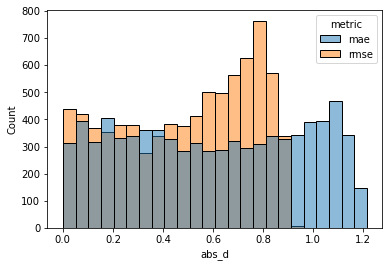

In [36]:
sns.histplot(data=sim_ri, x=sim_ri.abs_d, hue='metric', bins=bins)


In [179]:
sim_ri

,sim_number,metric,count,mean,std,min,0.05%,2.5%,50%,97.5%,...,pop_md,pop_pd,pop_d,type_s,sig,abs_d,d_bin,abs_popmd,pop_number,pop_rmsed
0,0,mae,6435.0,24.541100,3.519901,14.991730,15.020569,17.985028,24.405920,31.965003,...,22.145395,22.335705,0.991480,False,True,0.991480,0.986726,22.145395,0,28.745477
1,0,rmse,6435.0,29.251450,3.296986,19.373210,19.837821,22.841024,29.286144,35.735889,...,1934.811271,2476.262529,0.781343,False,True,0.781343,0.784348,1934.811271,0,28.745477
2,1,mae,6435.0,22.828026,3.110378,13.751717,14.581908,17.438564,22.588939,29.641916,...,22.145395,22.335705,0.991480,False,True,0.991480,0.986726,22.145395,0,28.745477
3,1,rmse,6435.0,29.492985,4.266395,19.479632,19.749188,22.179049,29.163028,38.594339,...,1934.811271,2476.262529,0.781343,False,True,0.781343,0.784348,1934.811271,0,28.745477
4,2,mae,6435.0,21.756646,1.218950,18.587637,18.852014,19.733277,21.637241,24.478090,...,22.145395,22.335705,0.991480,False,True,0.991480,0.986726,22.145395,0,28.745477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,7997,rmse,6435.0,22.497368,3.140347,15.449863,15.790980,17.286619,22.172683,29.372878,...,1523.466211,1999.742112,0.761831,False,True,0.761831,0.784348,1523.466211,1999,24.142721
15996,7998,mae,6435.0,18.218596,1.418326,13.426480,13.887047,15.528654,18.186653,21.022752,...,18.598181,20.450055,0.909444,False,True,0.909444,0.885537,18.598181,1999,24.142721
15997,7998,rmse,6435.0,22.851452,1.827491,15.840304,16.648360,19.099748,22.912924,26.215775,...,1523.466211,1999.742112,0.761831,False,True,0.761831,0.784348,1523.466211,1999,24.142721
15998,7999,mae,6435.0,17.724303,0.641137,16.102235,16.167677,16.589744,17.683240,19.077516,...,18.598181,20.450055,0.909444,False,True,0.909444,0.885537,18.598181,1999,24.142721


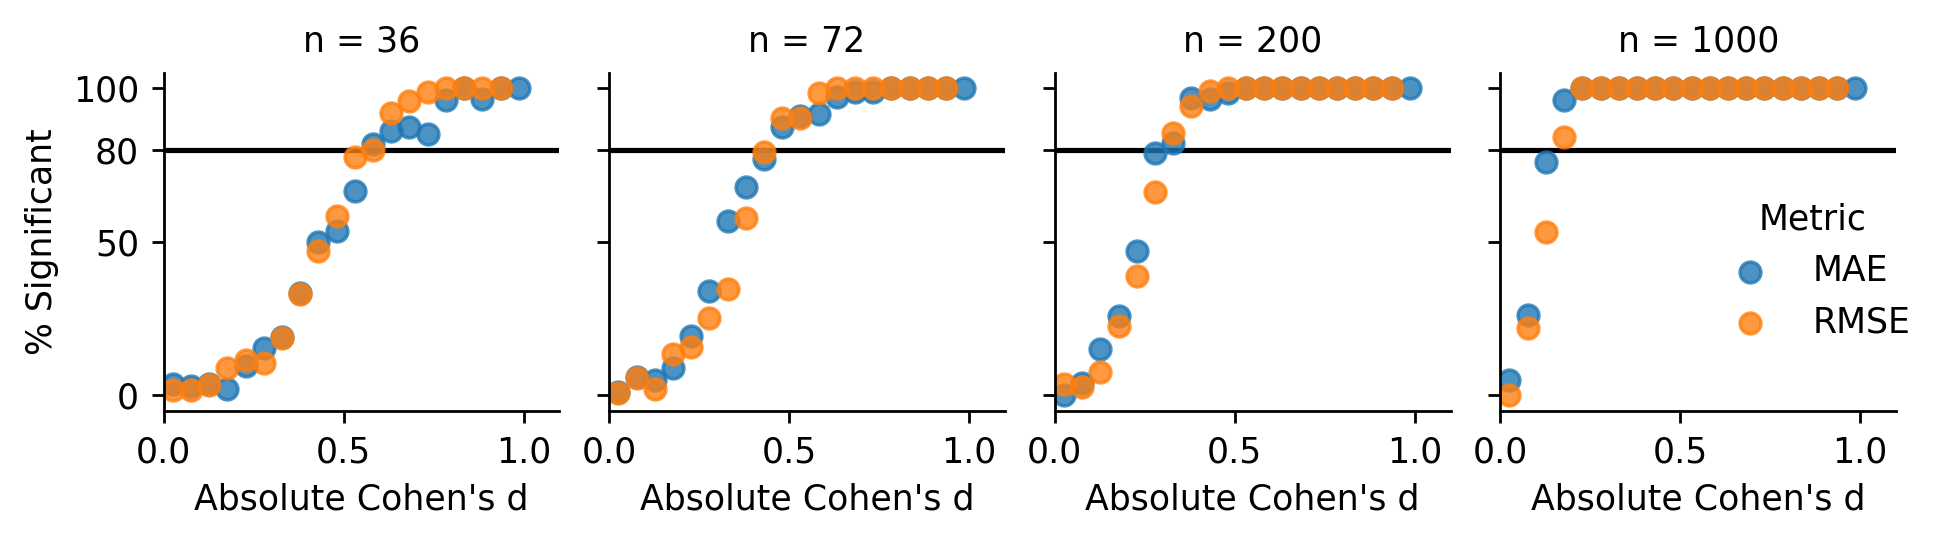

In [192]:
sig_rates = pd.DataFrame(sim_ri.query('abs_d < 1').groupby(['d_bin', 'metric', 'n']).sig.mean()).reset_index()
sig_rates['metric'] = sig_rates.metric.replace({'mae': 'MAE', 'rmse': 'RMSE'})
sig_rates['sig'] = sig_rates['sig'] * 100
sig_rates = sig_rates.rename(columns={'sig': '% Significant',
                                      'd_bin': "Absolute Cohen's d", 
                                      'metric': 'Metric'})
g = sns.lmplot(x="Absolute Cohen's d", y='% Significant',hue='Metric', col='n', data=sig_rates, fit_reg=False, lowess=True)
#g.ax.set_title('Power simulation for residual differences\non Weeks of Depression data.')
for ax in g.axes.flatten():
    ax.set_yticks((0,50,80,100))
    ax.hlines(80, 0, 1.1, 'black', zorder=0)
    ax.set_xlim((0,1.1))

g.fig.set_facecolor('white')
g.fig.set_dpi(250)
g.fig.set_size_inches(7.5,2)
g.fig.tight_layout()

In [111]:
sim_ri['abs_popmd'] = np.abs(sim_ri.pop_md)
sim_ri['pop_number'] = np.floor(sim_ri.sim_number/4).astype(int)

In [112]:
sim_ri.query('abs_d > 0.43 & abs_d < 0.46 & metric == "mae"').groupby('n').mean()

,sim_number,count,mean,std,min,0.05%,2.5%,50%,97.5%,99.95%,max,sig_pos,sig_neg,pop_md,pop_pd,pop_d,type_s,sig,abs_d,abs_popmd
n,,,,,,,,,,,,,,,,,,,,
36,4183.404255,6435.0,4.520330,2.876063,-4.153846,-3.431923,-0.757376,4.403448,10.422066,13.989425,15.054247,0.361702,0.170213,3.934515,15.772697,0.179986,0.0,0.531915,0.444448,7.011691
72,4184.404255,6435.0,3.865735,1.780235,-2.251947,-1.673713,0.353762,3.874718,7.319387,9.220432,9.729067,0.574468,0.234043,3.934515,15.772697,0.179986,0.0,0.808511,0.444448,7.011691
200,4185.404255,6435.0,4.285551,1.259510,0.207865,0.562004,1.859067,4.270341,6.787998,8.222219,8.601433,0.702128,0.276596,3.934515,15.772697,0.179986,0.0,0.978723,0.444448,7.011691
1000,4186.404255,6435.0,4.056771,0.546045,2.193668,2.359301,2.976024,4.062197,5.107597,5.681518,5.842177,0.702128,0.297872,3.934515,15.772697,0.179986,0.0,1.000000,0.444448,7.011691


Our simulations show that we had an 80.0% chance to detect a significant effect with an absolute population Cohen’s d between 0.43 and 0.46 and a sample of 72 participants when using MAE. This corresponds to an absolute mean MAE difference of 7.01 weeks assuming a pooled standard deviation of 15.77 weeks. Similarly, we found an 87.0% chance to detect a significant effect with an absolute population Cohen’s d between 0.43 and 0.46 and a sample of 72 participants when using RMSE. This corresponds to a mean squared error difference of 557.23 weeks^2 with a pooled standard deviation of 1254.47 weeks^2 or an average RMSE difference of 9.6 weeks. 
A minimally clinically significant difference of 2 weeks MAE corresponds to an absolute Cohen’s d of 0.056, which we had only a 5.3% power to detect. A difference of 2 weeks RMSE corresponds to an absolute Cohen’s d of 0.11, which we had only a 2.3% power to detect. If we had simply performed a comparison of linear models to determine if including family history of depression improved the model fit via an F-test we would have had 80% power to detect a 11.25% improvement in difference in r^2. We found the MFQ+FH model had an r^2 of 0.365 and that the total variance of weeks of depression was 329.83 weeks^2. Thus the MFQ+FH model explained 120.38 weeks^2 of variance. 11.25% of this corresponds to 13.54 weeks^2 or 3.68 weeks. Working backwards from our specified minimally clinically significant difference of 2 weeks, this corresponds to 4 weeks^2 of variance, or 3.32% of the variance explained by the MFQ+FH model. It would require a sample of 246 participants to have 80% power to detect a 3.32% difference in r^2.

In [171]:
3.68**2

13.5424

In [170]:
4/(np.var(wdat.c_ksadsdx_epset_annual_weeks_mdd) * 0.365)

0.03322560036032857

In [158]:
2/(np.var(wdat.c_ksadsdx_epset_annual_weeks_mdd) * 0.365)

0.016612800180164283

In [122]:
sim_ri.query('abs_popmd > 1.8 & abs_popmd < 2.4 & metric == "mae"').groupby('n').mean()

,sim_number,count,mean,std,min,0.05%,2.5%,50%,97.5%,99.95%,max,sig_pos,sig_neg,pop_md,pop_pd,pop_d,type_s,sig,abs_d,abs_popmd
n,,,,,,,,,,,,,,,,,,,,
36,3743.946667,6435.0,-0.561602,2.398929,-8.300072,-7.606305,-5.106238,-0.616375,4.289673,7.248528,8.130587,0.000000,0.000000,-0.672714,13.895196,-0.056407,0.0,0.000000,0.152271,2.108679
72,3744.946667,6435.0,-0.496850,1.778404,-6.210163,-5.676623,-3.847539,-0.542323,3.097799,5.260924,5.895078,0.026667,0.026667,-0.672714,13.895196,-0.056407,0.0,0.053333,0.152271,2.108679
200,3745.946667,6435.0,-0.552571,1.002603,-3.917861,-3.600510,-2.495698,-0.561697,1.433995,2.583296,2.919252,0.066667,0.106667,-0.672714,13.895196,-0.056407,0.0,0.173333,0.152271,2.108679
1000,3746.946667,6435.0,-0.704517,0.430146,-2.199407,-2.053751,-1.556444,-0.700664,0.128559,0.604971,0.744032,0.293333,0.626667,-0.672714,13.895196,-0.056407,0.0,0.920000,0.152271,2.108679


In [152]:
sim_ri.query('pop_rmsed > 1.8 & pop_rmsed < 2.4 & metric == "rmse"').groupby('n').mean()

,sim_number,count,mean,std,min,0.05%,2.5%,50%,97.5%,99.95%,...,sig_neg,pop_md,pop_pd,pop_d,type_s,sig,abs_d,abs_popmd,pop_number,pop_rmsed
n,,,,,,,,,,,,,,,,,,,,,
36,3677.904762,6435.0,0.163748,3.253601,-10.097876,-9.176721,-5.907707,0.053172,6.847188,11.000142,...,0.0,87.316006,821.008589,0.106965,0.0,0.00000,0.106965,87.316006,919.47619,2.130658
72,3678.904762,6435.0,1.596930,2.569472,-6.038102,-5.422982,-3.086827,1.476134,6.915456,10.229376,...,0.0,87.316006,821.008589,0.106965,0.0,0.02381,0.106965,87.316006,919.47619,2.130658
200,3679.904762,6435.0,1.797769,1.729269,-3.212484,-2.848729,-1.352654,1.716596,5.391469,7.599445,...,0.0,87.316006,821.008589,0.106965,0.0,0.02381,0.106965,87.316006,919.47619,2.130658
1000,3680.904762,6435.0,2.211430,0.771126,-0.315460,-0.104350,0.718669,2.205236,3.740540,4.642506,...,0.0,87.316006,821.008589,0.106965,0.0,0.50000,0.106965,87.316006,919.47619,2.130658


In [149]:
sim_ri.query('abs_d > 0.43 & abs_d < 0.46 & metric == "rmse"').groupby('n').mean()

,sim_number,count,mean,std,min,0.05%,2.5%,50%,97.5%,99.95%,...,sig_neg,pop_md,pop_pd,pop_d,type_s,sig,abs_d,abs_popmd,pop_number,pop_rmsed
n,,,,,,,,,,,,,,,,,,,,,
36,3476.888889,6435.0,8.267137,4.031255,-3.123016,-2.252481,1.095292,8.017109,16.793098,22.262973,...,0.055556,505.221047,1254.472302,0.328959,0.0,0.537037,0.44407,557.232711,869.222222,9.618345
72,3477.888889,6435.0,9.336816,2.708841,0.981123,1.703774,4.295529,9.238173,14.883929,18.285542,...,0.074074,505.221047,1254.472302,0.328959,0.0,0.870370,0.44407,557.232711,869.222222,9.618345
200,3478.888889,6435.0,9.154731,1.710080,3.626149,4.088479,5.867535,9.136240,12.539251,14.459256,...,0.111111,505.221047,1254.472302,0.328959,0.0,0.981481,0.44407,557.232711,869.222222,9.618345
1000,3479.888889,6435.0,9.489819,0.857825,6.617180,6.875185,7.809516,9.491829,11.168570,12.114037,...,0.129630,505.221047,1254.472302,0.328959,0.0,1.000000,0.44407,557.232711,869.222222,9.618345


In [116]:
sim_info['abs_d'] = np.abs(sim_info.pop_d)

In [138]:
power_inds = np.unique(sim_ri.query('abs_d > 0.43 & abs_d < 0.46 & metric == "rmse" & n == 72').pop_number.values)

array([   3,   19,   57,   63,  103,  135,  255,  285,  292,  319,  326,
        427,  430,  439,  441,  474,  606,  608,  609,  614,  637,  650,
        658,  659,  730,  752,  773,  799,  813,  854,  878,  897,  958,
       1029, 1031, 1040, 1076, 1139, 1163, 1168, 1275, 1385, 1421, 1495,
       1519, 1569, 1640, 1657, 1664, 1685, 1801, 1835, 1868, 1915])

In [137]:
power_inds

array([   3,   19,   57,   63,  103,  135,  255,  285,  292,  319,  326,
        427,  430,  439,  441,  474,  606,  608,  609,  614,  637,  650,
        658,  659,  730,  752,  773,  799,  813,  854,  878,  897,  958,
       1029, 1031, 1040, 1076, 1139, 1163, 1168, 1275, 1385, 1421, 1495,
       1519, 1569, 1640, 1657, 1664, 1685, 1801, 1835, 1868, 1915])

In [136]:
(np.sqrt(pop_sims_sq[:, power_inds].mean(0)) - np.sqrt(pop_nulls_sq[:, power_inds].mean(0))).mean()

9.618344597658282

In [148]:
rmsed = pd.DataFrame({'pop_number': range(pop_sims_sq.shape[1]), 'pop_rmsed': (np.sqrt(pop_sims_sq.mean(0)) - np.sqrt(pop_nulls_sq.mean(0)))})
sim_ri = sim_ri.merge(rmsed, how='left', on='pop_number')